In [61]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O cats_and_dogs_filtered.zip

--2021-08-09 12:35:03--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 64.233.184.128, 64.233.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   127MB/s    in 0.5s    

2021-08-09 12:35:04 (127 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [62]:
! unzip -q cats_and_dogs_filtered.zip

replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [63]:
train_dir = "cats_and_dogs_filtered/train"
validation_dir = "cats_and_dogs_filtered/validation"

## Primero como siempre importamos los datos

In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Ahora importamos la red y los pesos de la red VGG16

In [65]:
from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [66]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Setear los parámetros del modelo base a no entrenable

In [67]:
vgg_base.trainable=False 

### Ahora hay que agregar las últimas capas de la red:

In [68]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(vgg_base)
# agregar el final de la red
# una capa flatten
# una capa densa de 256 elementos
# una capa sigmoidea
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

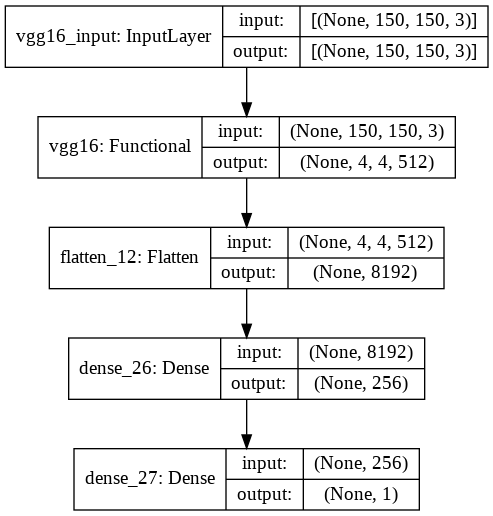

In [69]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Entrenamos el modelo

In [70]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [71]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=3,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
100/100 [==============================] - 27s 265ms/step - loss: 0.5916 - acc: 0.6885 - val_loss: 0.4564 - val_acc: 0.7980
Epoch 2/3
100/100 [==============================] - 26s 263ms/step - loss: 0.4859 - acc: 0.7755 - val_loss: 0.3687 - val_acc: 0.8500
Epoch 3/3
100/100 [==============================] - 26s 263ms/step - loss: 0.4322 - acc: 0.8120 - val_loss: 0.3335 - val_acc: 0.8620


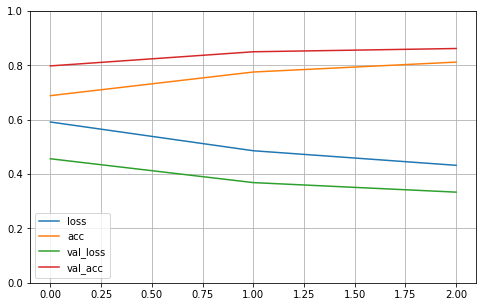

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# TAREA: Hacer lo mismo con ResNet50:

In [73]:
from tensorflow.keras.applications import ResNet50
base_resnet = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(150, 150, 3),
    pooling='avg',
    classes=1000,
)

In [74]:
base_resnet.trainable=False 

In [79]:
resnet = models.Sequential()
resnet.add(base_resnet)
resnet.add(layers.Flatten())
resnet.add(layers.Dense(2048, activation='relu'))
resnet.add(layers.Dense(256, activation='relu'))
resnet.add(layers.Dense(1, activation='sigmoid'))


In [80]:
resnet.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


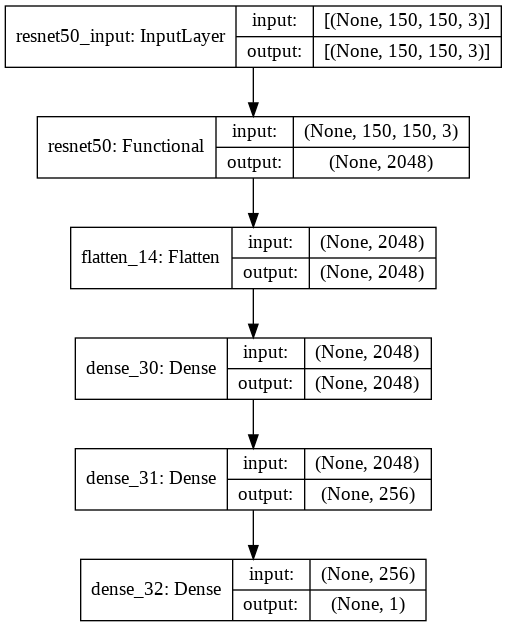

In [81]:
from tensorflow.keras.utils import plot_model
plot_model(resnet, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [82]:
history = resnet.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 78s 267ms/step - loss: 0.6960 - accuracy: 0.5280 - val_loss: 0.6773 - val_accuracy: 0.5850
Epoch 2/10
100/100 [==============================] - 25s 251ms/step - loss: 0.6842 - accuracy: 0.5760 - val_loss: 0.6785 - val_accuracy: 0.5700
Epoch 3/10
100/100 [==============================] - 25s 251ms/step - loss: 0.6916 - accuracy: 0.5430 - val_loss: 0.7015 - val_accuracy: 0.5340
Epoch 4/10
100/100 [==============================] - 25s 254ms/step - loss: 0.6943 - accuracy: 0.5590 - val_loss: 0.7164 - val_accuracy: 0.5250
Epoch 5/10
100/100 [==============================] - 25s 251ms/step - loss: 0.6904 - accuracy: 0.5425 - val_loss: 0.6709 - val_accuracy: 0.5850
Epoch 6/10
100/100 [==============================] - 25s 255ms/step - loss: 0.6794 - accuracy: 0.5700 - val_loss: 0.7103 - val_accuracy: 0.5020
Epoch 7/10
100/100 [==============================] - 25s 251ms/step - loss: 0.6808 - accuracy: 0.5705 - val_loss: 0.7185 - val_ac